In [173]:

from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) #Evitar avisos por versiones obsoletas futuras


@dataclass(slots=True)
class SportsEDAPipeline:
    path_csv: Path | str
    def cargar_csv(self):
        path = Path(self.path_csv)
        if not path.exists():
            raise FileNotFoundError(f"No existe el fichero CSV: {path}")
        return pd.read_csv(path)

    
    def convertir_ids(self, df, keep_raw = False):
        df = df.copy()

        df['Athlete_ID_raw'] = df['Athlete_ID']

        s = df['Athlete_ID'].astype(str).str.strip().str.upper()
        digits = s.str.extract(r'^A\s*0*(\d+)$', expand=False)

        df['Athlete_ID'] = (pd.to_numeric(digits, errors='coerce') + 1)
        display(df[['Athlete_ID_raw', 'Athlete_ID']].head(10))

        n_na = int(df['Athlete_ID'].isna().sum())
        if n_na == 0:
            df['Athlete_ID'] = df['Athlete_ID'].astype(int)
            if not keep_raw:
                df.drop(columns='Athlete_ID_raw', inplace=True)
        else:
            df['Athlete_ID'] = df['Athlete_ID'].astype('Int64')

        df['Session_ID_raw'] = df['Session_ID']

        s = df['Session_ID'].astype(str).str.strip().str.upper()
        digits = s.str.extract(r'^S\s*0*(\d+)$', expand=False)

        df['Session_ID'] = (pd.to_numeric(digits, errors='coerce') + 1)
        display(df[['Session_ID_raw', 'Session_ID']].head(10))

        n_na = int(df['Session_ID'].isna().sum())
        if n_na == 0:
            df['Session_ID'] = df['Session_ID'].astype(int)
            if not keep_raw:
                df.drop(columns='Session_ID_raw', inplace=True)
        else:
            df['Session_ID'] = df['Session_ID'].astype('Int64')

        return df


    def convertir_columnas_restantes(self, df):

        # Gender → categórico
        df["Gender"] = df["Gender"].astype(str).str.strip().str.upper()
        df["Gender"] = df["Gender"].astype(pd.CategoricalDtype(categories=["M", "F"]))

        # Fatigue → categórico
        order = ["Low", "Medium", "High"]
        df["Fatigue"] = df["Fatigue"].astype(str).str.strip().str.title()
        df["Fatigue"] = df["Fatigue"].astype(pd.CategoricalDtype(categories=order, ordered=True))

        # Sport y Exercise → string
        for col in ["Sport", "Exercise"]:
            df[col] = df[col].astype(str).str.strip().astype(pd.StringDtype())

        # Injury_Risk → categórico
        df["Injury_Risk"] = pd.to_numeric(df["Injury_Risk"], errors="coerce")
        df["Injury_Risk"] = df["Injury_Risk"].astype(pd.CategoricalDtype(categories=[0, 1, 2], ordered=True))

        return df

    def reporte_nulos(self, df):
        n = df.isnull().sum()
        pct = (n / len(df)) * 100
        return pd.DataFrame({"n_null": n, "pct_null": pct})

    def eliminar_duplicados(self, df):
        return df.drop_duplicates().copy()

    def describir_numericas(self, df):
        cols = df.select_dtypes(include=["number"]).columns
        return df[list(cols)].describe().T

    def tabla_frecuencias(self, df, col):
        vc = df[col].value_counts(dropna=False).sort_index()
        total = int(vc.sum())
        pct = (vc / total) * 100
        return pd.DataFrame({col: vc.index, "count": vc.values, "pct": pct.values})

    def histograma(self, df, col, bins):
        s = df[col].dropna()
        plt.figure(figsize=(6, 4))
        plt.hist(s, bins=bins, color="skyblue", edgecolor="black")
        plt.title(f"Histograma de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(alpha=0.3)
        plt.show()
        
    def stem_plot(self, df, col):
        counts = df[col].value_counts().sort_index()
        plt.figure(figsize=(7, 4))
        markerline, stemlines, baseline = plt.stem(counts.index, counts.values)
        plt.setp(markerline, "markerfacecolor", "k")
        plt.title(f"Stem plot de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.show()    

    def boxplot(self,df, col):
        s = df[col].dropna()
        plt.figure(figsize=(6, 2))
        plt.boxplot(s, vert=False, patch_artist=True)
        plt.title(f"Boxplot de {col}")
        plt.xlabel(col)
        plt.grid(alpha=0.3)
        plt.show()
        
    def mostrar_graficos(self, df, bins=10):
   
        import pandas as pd
        from pandas.api.types import is_numeric_dtype, is_string_dtype
        import matplotlib.pyplot as plt
        
        columnas = df.columns.drop(["Athlete_ID", "Session_ID"])
        n = len(columnas)
        fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n)) 
        fig.tight_layout(pad=4)

        for i, col in enumerate(columnas):
            s = df[col].dropna()

           
            if is_numeric_dtype(s):  
                # Histograma
                axes[i, 0].hist(s, bins=bins, color="skyblue", edgecolor="black")
                axes[i, 0].set_title(f"Histograma de {col}")
                axes[i, 0].set_ylabel("Frecuencia")

                # Stem plot
                counts = s.value_counts().sort_index()
                markerline, stemlines, baseline = axes[i, 1].stem(counts.index, counts.values)
                plt.setp(markerline, "markerfacecolor", "k")
                axes[i, 1].set_title(f"Stem plot de {col}")

                # Boxplot
                axes[i, 2].boxplot(s, vert=False, patch_artist=True)
                axes[i, 2].set_title(f"Boxplot de {col}")

            elif isinstance(s.dtype, pd.CategoricalDtype):  
                counts = s.value_counts().sort_index()
                markerline, stemlines, baseline = axes[i, 0].stem(counts.index, counts.values)
                plt.setp(markerline, "markerfacecolor", "k")
                axes[i, 0].set_title(f"Stem plot de {col}")
                axes[i, 1].axis("off")
                axes[i, 2].axis("off")

            elif is_string_dtype(s) or s.dtype == "object":  
                counts = s.value_counts().sort_index()
                axes[i, 0].bar(counts.index, counts.values, color="skyblue", edgecolor="black")
                axes[i, 0].set_title(f"Histograma de {col}")
                axes[i, 0].tick_params(axis="x", rotation=45)

                markerline, stemlines, baseline = axes[i, 1].stem(counts.index, counts.values)
                plt.setp(markerline, "markerfacecolor", "k")
                axes[i, 1].set_title(f"Stem plot de {col}")

        plt.show()


    def mostrar_tablas_frecuencias(self, df):
        for col in df.columns:
            tabla = self.tabla_frecuencias(df, col)
            display(tabla)

    


In [174]:

# Ruta al dataset
path = r"C:\Users\migue\OneDrive\Documentos\5º\Proyectos II\iot_sports_training_dataset.csv"

# Crear el pipeline
pipe = SportsEDAPipeline(path_csv=path)

# Cargar el CSV
sptr = pipe.cargar_csv()

# Mostrar información básica
display(sptr.head())
sptr.info()
sptr.describe(include='all')


,Athlete_ID,Age,Gender,Sport,HR,RR,Temp,Accel_X,Accel_Y,Accel_Z,...,Steps,Session_ID,Exercise,Duration,Fatigue,Injury_Risk,PSD_HR,PSD_Accel_X,PSD_Gyro_Y,Performance_Score
0,A0000,24,M,Basketball,137,17,36.2,1.37,0.49,1.11,...,5524,S0000,Running,31,Medium,1,0.73,0.70,0.53,72
1,A0001,32,F,Basketball,146,10,36.3,0.29,0.25,0.70,...,4459,S0001,Endurance,22,Medium,1,0.62,0.44,0.52,48
2,A0002,28,F,Basketball,135,21,36.3,0.89,0.25,1.27,...,4992,S0002,Endurance,58,Low,1,0.97,0.54,0.54,56
3,A0003,25,M,Basketball,119,20,36.6,0.38,0.43,1.06,...,1203,S0003,Drills,33,Medium,0,0.80,0.66,0.25,47
4,A0004,24,F,Football,177,17,36.6,0.22,1.33,1.24,...,3775,S0004,Running,47,Medium,0,0.55,0.52,0.59,69


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Athlete_ID         500 non-null    object 
 1   Age                500 non-null    int64  
 2   Gender             500 non-null    object 
 3   Sport              500 non-null    object 
 4   HR                 500 non-null    int64  
 5   RR                 500 non-null    int64  
 6   Temp               500 non-null    float64
 7   Accel_X            500 non-null    float64
 8   Accel_Y            500 non-null    float64
 9   Accel_Z            500 non-null    float64
 10  Gyro_X             500 non-null    float64
 11  Gyro_Y             500 non-null    float64
 12  Gyro_Z             500 non-null    float64
 13  Steps              500 non-null    int64  
 14  Session_ID         500 non-null    object 
 15  Exercise           500 non-null    object 
 16  Duration           500 non

,Athlete_ID,Age,Gender,Sport,HR,RR,Temp,Accel_X,Accel_Y,Accel_Z,...,Steps,Session_ID,Exercise,Duration,Fatigue,Injury_Risk,PSD_HR,PSD_Accel_X,PSD_Gyro_Y,Performance_Score
count,500,500.000000,500,500,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500,500,500.000000,500,500.000000,500.000000,500.000000,500.000000,500.000000
unique,500,NaN,2,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500,5,NaN,3,NaN,NaN,NaN,NaN,NaN
top,A0000,NaN,M,Cycling,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,S0000,Drills,NaN,Medium,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,263,106,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,122,NaN,209,NaN,NaN,NaN,NaN,NaN
mean,NaN,25.754000,NaN,NaN,128.936000,16.87600,36.530400,0.846240,0.843300,0.847520,...,3484.326000,NaN,NaN,40.328000,NaN,0.516000,0.758660,0.550040,0.397640,52.670000
std,NaN,5.089724,NaN,NaN,29.156407,4.36012,0.501696,0.379567,0.368719,0.376942,...,1397.847519,NaN,NaN,11.619054,NaN,0.668309,0.143577,0.148783,0.114237,11.029797
min,NaN,18.000000,NaN,NaN,80.000000,10.00000,35.000000,0.200000,0.200000,0.200000,...,1048.000000,NaN,NaN,20.000000,NaN,0.000000,0.500000,0.300000,0.200000,17.000000
25%,NaN,21.000000,NaN,NaN,105.000000,13.00000,36.200000,0.550000,0.520000,0.520000,...,2289.000000,NaN,NaN,30.000000,NaN,0.000000,0.640000,0.420000,0.300000,44.000000
50%,NaN,25.000000,NaN,NaN,127.000000,17.00000,36.500000,0.830000,0.860000,0.835000,...,3487.000000,NaN,NaN,40.000000,NaN,0.000000,0.765000,0.550000,0.400000,53.000000
75%,NaN,30.000000,NaN,NaN,155.000000,21.00000,36.900000,1.182500,1.150000,1.182500,...,4647.750000,NaN,NaN,51.000000,NaN,1.000000,0.880000,0.680000,0.500000,61.000000


In [175]:
sptr=pipe.convertir_ids(sptr)
sptr = pipe.convertir_columnas_restantes(sptr)

sptr.describe(include='all')
sptr.info()


,Athlete_ID_raw,Athlete_ID
0,A0000,1
1,A0001,2
2,A0002,3
3,A0003,4
4,A0004,5
5,A0005,6
6,A0006,7
7,A0007,8
8,A0008,9
9,A0009,10


,Session_ID_raw,Session_ID
0,S0000,1
1,S0001,2
2,S0002,3
3,S0003,4
4,S0004,5
5,S0005,6
6,S0006,7
7,S0007,8
8,S0008,9
9,S0009,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Athlete_ID         500 non-null    int32   
 1   Age                500 non-null    int64   
 2   Gender             500 non-null    category
 3   Sport              500 non-null    string  
 4   HR                 500 non-null    int64   
 5   RR                 500 non-null    int64   
 6   Temp               500 non-null    float64 
 7   Accel_X            500 non-null    float64 
 8   Accel_Y            500 non-null    float64 
 9   Accel_Z            500 non-null    float64 
 10  Gyro_X             500 non-null    float64 
 11  Gyro_Y             500 non-null    float64 
 12  Gyro_Z             500 non-null    float64 
 13  Steps              500 non-null    int64   
 14  Session_ID         500 non-null    int32   
 15  Exercise           500 non-null    string  
 16  Duration

In [176]:
# Ver nulos y porcentaje
display(pipe.reporte_nulos(sptr))

# Eliminar duplicados si los hubiera
sptr = pipe.eliminar_duplicados(sptr)


,n_null,pct_null
Athlete_ID,0,0.0
Age,0,0.0
Gender,0,0.0
Sport,0,0.0
HR,0,0.0
RR,0,0.0
Temp,0,0.0
Accel_X,0,0.0
Accel_Y,0,0.0
Accel_Z,0,0.0


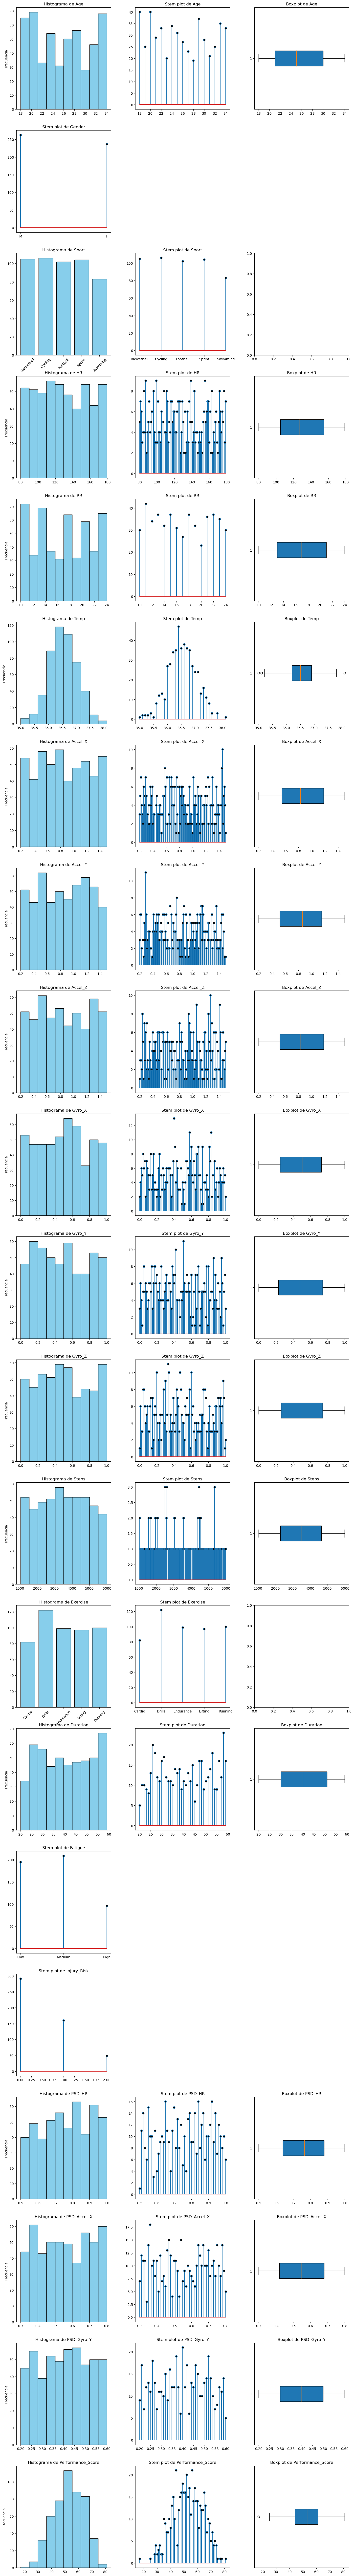

In [177]:
pipe.mostrar_graficos(sptr)


In [178]:
# Describe numérico
display(pipe.describir_numericas(sptr))



,count,mean,std,min,25%,50%,75%,max
Athlete_ID,500.0,250.50000,144.481833,1.0,125.75,250.500,375.2500,500.0
Age,500.0,25.75400,5.089724,18.0,21.00,25.000,30.0000,34.0
HR,500.0,128.93600,29.156407,80.0,105.00,127.000,155.0000,179.0
RR,500.0,16.87600,4.360120,10.0,13.00,17.000,21.0000,24.0
Temp,500.0,36.53040,0.501696,35.0,36.20,36.500,36.9000,38.1
Accel_X,500.0,0.84624,0.379567,0.2,0.55,0.830,1.1825,1.5
Accel_Y,500.0,0.84330,0.368719,0.2,0.52,0.860,1.1500,1.5
Accel_Z,500.0,0.84752,0.376942,0.2,0.52,0.835,1.1825,1.5
Gyro_X,500.0,0.49374,0.285137,0.0,0.25,0.505,0.7300,1.0
Gyro_Y,500.0,0.48724,0.290660,0.0,0.23,0.480,0.7425,1.0


In [179]:
pipe.mostrar_tablas_frecuencias (sptr)

,Athlete_ID,count,pct
0,1,1,0.2
1,2,1,0.2
2,3,1,0.2
3,4,1,0.2
4,5,1,0.2
...,...,...,...
495,496,1,0.2
496,497,1,0.2
497,498,1,0.2
498,499,1,0.2


,Age,count,pct
0,18,40,8.0
1,19,25,5.0
2,20,40,8.0
3,21,29,5.8
4,22,33,6.6
5,23,20,4.0
6,24,34,6.8
7,25,31,6.2
8,26,27,5.4
9,27,23,4.6


,Gender,count,pct
0,M,263,52.6
1,F,237,47.4


,Sport,count,pct
0,Basketball,105,21.0
1,Cycling,106,21.2
2,Football,102,20.4
3,Sprint,104,20.8
4,Swimming,83,16.6


,HR,count,pct
0,80,5,1.0
1,81,7,1.4
2,82,6,1.2
3,83,3,0.6
4,84,4,0.8
...,...,...,...
94,175,6,1.2
95,176,5,1.0
96,177,8,1.6
97,178,3,0.6


,RR,count,pct
0,10,30,6.0
1,11,42,8.4
2,12,34,6.8
3,13,37,7.4
4,14,32,6.4
5,15,37,7.4
6,16,31,6.2
7,17,27,5.4
8,18,37,7.4
9,19,32,6.4


,Temp,count,pct
0,35.0,1,0.2
1,35.1,2,0.4
2,35.2,2,0.4
3,35.3,2,0.4
4,35.4,3,0.6
5,35.5,1,0.2
6,35.6,8,1.6
7,35.7,12,2.4
8,35.8,13,2.6
9,35.9,10,2.0


,Accel_X,count,pct
0,0.20,3,0.6
1,0.21,5,1.0
2,0.22,7,1.4
3,0.23,4,0.8
4,0.24,3,0.6
...,...,...,...
120,1.46,2,0.4
121,1.47,5,1.0
122,1.48,6,1.2
123,1.49,4,0.8


,Accel_Y,count,pct
0,0.20,3,0.6
1,0.21,6,1.2
2,0.22,6,1.2
3,0.23,2,0.4
4,0.25,3,0.6
...,...,...,...
122,1.45,2,0.4
123,1.46,6,1.2
124,1.47,4,0.8
125,1.48,1,0.2


,Accel_Z,count,pct
0,0.20,1,0.2
1,0.21,3,0.6
2,0.22,3,0.6
3,0.23,2,0.4
4,0.24,8,1.6
...,...,...,...
124,1.46,6,1.2
125,1.47,3,0.6
126,1.48,2,0.4
127,1.49,4,0.8


,Gyro_X,count,pct
0,0.00,2,0.4
1,0.01,4,0.8
2,0.02,6,1.2
3,0.03,5,1.0
4,0.04,8,1.6
...,...,...,...
94,0.96,4,0.8
95,0.97,6,1.2
96,0.98,4,0.8
97,0.99,5,1.0


,Gyro_Y,count,pct
0,0.00,3,0.6
1,0.01,6,1.2
2,0.02,4,0.8
3,0.03,1,0.2
4,0.04,5,1.0
...,...,...,...
94,0.96,6,1.2
95,0.97,1,0.2
96,0.98,5,1.0
97,0.99,7,1.4


,Gyro_Z,count,pct
0,0.00,1,0.2
1,0.01,6,1.2
2,0.02,3,0.6
3,0.03,3,0.6
4,0.04,8,1.6
...,...,...,...
95,0.96,6,1.2
96,0.97,9,1.8
97,0.98,7,1.4
98,0.99,1,0.2


,Steps,count,pct
0,1048,2,0.4
1,1065,1,0.2
2,1066,1,0.2
3,1081,1,0.2
4,1086,1,0.2
...,...,...,...
472,5917,1,0.2
473,5934,1,0.2
474,5958,1,0.2
475,5964,1,0.2


,Session_ID,count,pct
0,1,1,0.2
1,2,1,0.2
2,3,1,0.2
3,4,1,0.2
4,5,1,0.2
...,...,...,...
495,496,1,0.2
496,497,1,0.2
497,498,1,0.2
498,499,1,0.2


,Exercise,count,pct
0,Cardio,82,16.4
1,Drills,122,24.4
2,Endurance,99,19.8
3,Lifting,97,19.4
4,Running,100,20.0


,Duration,count,pct
0,20,5,1.0
1,21,10,2.0
2,22,10,2.0
3,23,9,1.8
4,24,8,1.6
5,25,13,2.6
6,26,20,4.0
7,27,18,3.6
8,28,12,2.4
9,29,11,2.2


,Fatigue,count,pct
0,Low,195,39.0
1,Medium,209,41.8
2,High,96,19.2


,Injury_Risk,count,pct
0,0,291,58.2
1,1,160,32.0
2,2,49,9.8


,PSD_HR,count,pct
0,0.50,1,0.2
1,0.51,11,2.2
2,0.52,14,2.8
3,0.53,8,1.6
4,0.54,6,1.2
5,0.55,15,3.0
6,0.56,10,2.0
7,0.57,10,2.0
8,0.58,3,0.6
9,0.59,11,2.2


,PSD_Accel_X,count,pct
0,0.30,7,1.4
1,0.31,12,2.4
2,0.32,11,2.2
3,0.33,11,2.2
4,0.34,3,0.6
5,0.35,14,2.8
6,0.36,18,3.6
7,0.37,10,2.0
8,0.38,11,2.2
9,0.39,8,1.6


,PSD_Gyro_Y,count,pct
0,0.20,9,1.8
1,0.21,17,3.4
2,0.22,7,1.4
3,0.23,12,2.4
4,0.24,13,2.6
5,0.25,11,2.2
6,0.26,18,3.6
7,0.27,13,2.6
8,0.28,7,1.4
9,0.29,11,2.2


,Performance_Score,count,pct
0,17,1,0.2
1,25,1,0.2
2,28,2,0.4
3,29,4,0.8
4,30,2,0.4
5,31,3,0.6
6,32,4,0.8
7,33,2,0.4
8,34,2,0.4
9,35,10,2.0
